# With this notebook we will:
## 1. Install packages needed for root
## 2. Download a binary root that compiled in google drive "colaboratory" environement
## 3. Modify the PATH in order to tell python where to look for pyROOT
## 4. Finally, a basic analysis example with pyROOT

##### Author: Jose Ruiz
##### Maintainer: Jose Ruiz
##### Developed at: Universidad de Antioquia


### 1. Install packages needed for root

In [1]:
!apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libxext-dev is already the newest version (2:1.3.3-1).
libxext-dev set to manually installed.
libxft-dev is already the newest version (2.3.2-1).
binutils is already the newest version (2.30-21ubuntu1~18.04.2).
binutils set to manually installed.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
gcc is already the newest version (4:7.4.0-1ubuntu2.3).
gcc set to manually installed.
gfortran is already the newest version (4:7.4.0-1ubuntu2.3).
git is already the newest version (1:2.17.1-1ubuntu0.4).
libx11-dev is already the newest version (2:1.6.4-3ubuntu0.2).
libx11-dev set to manually installed.
tar is already the newest version (1.29b-2ubuntu0.1).
The following additional packages will be installed:
  libapr1 libaprutil1 libdpkg-perl libserf-1-1 libsvn1
Suggested packages:
  debian-keyring bz

### 2. Mount the drive to get the root binary and untar it 

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/Shared drives/PyROOT_in_Google/"

BasicAnalysis.ipynb	  HistogrammingInROOT.ipynb
BasicPyROOTExample.ipynb  monje-a-lo-bonzo-blanco-y-negro.png
Chi2Fitting.ipynb	  piano-C5.wav
Data5.root		  Random2DHistos
DatosParcial2		  root_build_google_yikes.tar
DatosResonancia.root	  Temporal
FFT_imagen.ipynb	  TrimmedTree.root
FFT.ipynb		  TTreeExcercise.ipynb
FLUTEMI.WAV


In [0]:
!tar -xf /content/drive/Shared\ drives/PyROOT_in_Google/root_build_google_yikes.tar

In [5]:
!ls -ltrh

total 12K
drwxr-xr-x 44 root root 4.0K Sep 20  2018 root_build
drwxr-xr-x  1 root root 4.0K Nov  6 16:17 sample_data
drwx------  4 root root 4.0K Nov 17 15:39 drive



### 3. Modify the PATH in order to tell python where to look for pyROOT


In [0]:
import sys
sys.path.append("/content/root_build/")
sys.path.append("/content/root_build/bin/")
sys.path.append("/content/root_build/include/")
sys.path.append("/content/root_build/lib/")

# Now let's analyze the data contained in NXX.root file

### Importing necessary libraries

In [7]:
import ROOT

Welcome to JupyROOT 6.14/04


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import time 

### Reading the file 


In [9]:
DataN = ROOT.TChain('SystemTree')
DataN.Add("/content/drive/Shared drives/PyROOT_in_Google/DatosParcial2/N1037667562.root")

1

### Getting the number of events contained in the tree

In [10]:
NumberOfEventsToCheck=DataN.GetEntries() #cuenta cuantas entradas hay en la cadena 
print("We are going to analyze ", NumberOfEventsToCheck, " events")

We are going to analyze  85000  events


### 1) Creating histogram for the data

In [0]:
DMP = ROOT.TH1F( 'DMP', 'Parcial2 Data', 200, 100, 1100 ) #crea histograma

for entry in DataN:
  DMP.Fill(entry.x) # Llena el histograma con los eventos del TTree

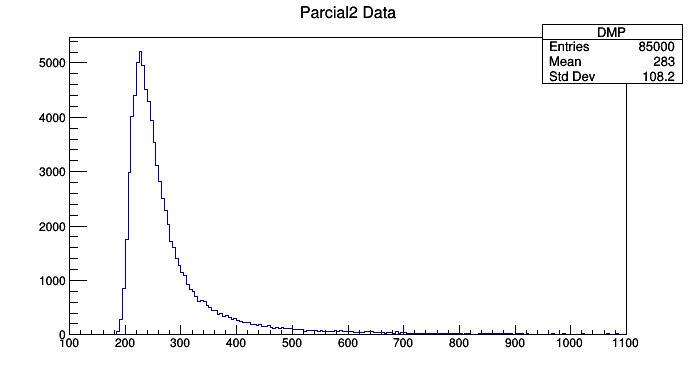

In [12]:
# TCanvas crea ventana para las gráficas
c1 = ROOT.TCanvas( 'c1', 'first canvas', 100, 10, 700, 400 ) 
c1.SetFillColor( 0 )
DMP.Draw()
c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

Creando funciones que necesitaremos para el método de Metropolis y el método de chi cuadrado

In [0]:
# =========== Método de Metropolis siguiendo distribución de Landau  ========
#--- Entradas: tupla con argumentos (mu, c), limites del histograma y N de eventos
def Metr_code(fargs, upp, down, N):
  ''' Crea Histograma con el método de metropolis para la distribución de Landau '''
  mu, c = fargs  # Argumentos 
  phi0 = (upp-down)*np.random.random_sample() + down # Inicializando phi0
  
  n=0 #contador número de eventos
  PHI = [] #lista donde llenaremos los eventos aprobados 
  while n<N:
    phip = (upp-down)*np.random.random_sample() + down # Tomando phip por iteración

    if ROOT.TMath.Landau( phi0, mu, c, True) != 0: #evita error de division por cero
      ds = -np.log(ROOT.TMath.Landau( phip, mu, c, True)/ROOT.TMath.Landau( phi0, mu, c, True))
      
      if ds<0: #condición aprobado 1
        phi0=phip
        PHI.append(phi0)
        n+=1
      elif ds>0: 
        comp = np.random.random_sample()
        pr = ROOT.TMath.Landau( phip, mu, c, True)/ROOT.TMath.Landau( phi0, mu, c, True)
        if pr>comp: #condición aprobado 2 
          phi0=phip
          PHI.append(phi0)
          n+=1
        elif pr<comp: # no aprobado 
          continue
  return PHI

In [0]:
#======== Definimos calculo de Chi-Cuadrado entre dos histogramas de ROOT =======
#---- Entradas: Los histogramas que se desean comparar 

def chi_hist(X, Y):
  num = X.GetSize() #obtenemos número de bines 
  if num == Y.GetSize(): # Verificamos que si tenga el mismo nbin 
    ssum = 0
    for i in range(1, num+1):
      if X.GetBinContent(i) == 0: # no contamos los bines en data iguales a 0
        pass # evita división por cero 
      else:
        ssum += (X.GetBinContent(i) - Y.GetBinContent(i))**2 / X.GetBinContent(i)

    return ssum/num #Devuelve valor de Chi2 dividido por el numero de bins
    
  else: # Informamos al usuario cuando no tengan el mismo nbin los X Y ingresados
    print("No tienen el mismo número de bins")
    return False

Note que el valor que retorna mi función para calcular $\chi^2$ es en realidad $\frac{\chi^2}{ndf}$ de manera que, de aquí en adelante, cuando se hable de $\chi^2$ se estará haciendo referencia a $\frac{\chi^2}{ndf}$, que es el valor que calculo

In [0]:
#======== Función para crear histograma de ROOT con Metodo de Metropolis ======
#---- Entradas: Argumentos en tupla (mu, c); numero de bines; numero de eventos

def nw_hist(argsL, bbin, num_ev):
  upp = 1100 #fijamos los límites del histograma 
  down = 100

  HIST = ROOT.TH1F( 'HIST', "Landau's histogram", bbin, down, upp ) #crea histograma ROOT

  datf = Metr_code(argsL, upp, down, num_ev) # Crea histograma Metropolis

  for jj in datf: #Llenamos histograma ROOT con datos de metropolis 
    HIST.Fill(jj)

  return HIST

A continuación generaremos un primer histograma con el método propuesto usando valor de $\mu$ cercano a la media y c aproximadamente un orden de magnitud menor a la desviación estandar.

In [16]:
#==== Generando primer histograma ====
#--- el numero de bines y de entradas definidos en esta celda,
#--- son los que se usarán en el resto del código

arg1 = (280, 15) #argumentos del primer histograma 
bines = 200  # número de bines 
n_ent = DataN.GetEntries() # número de eventos 

Hist1 = nw_hist(arg1, bines, n_ent) # Genera histograma 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


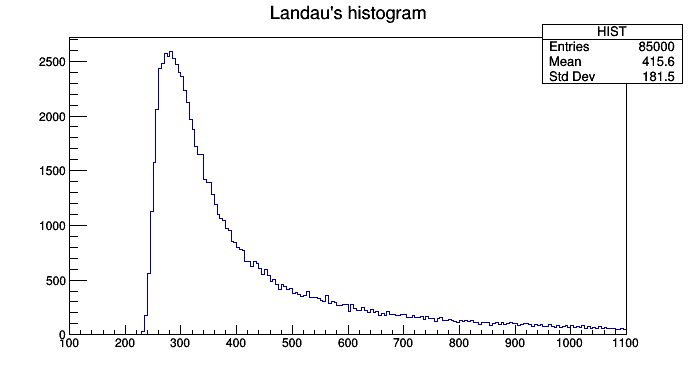

In [17]:
#======= Graficamos el primer histograma generado =======

Hist1.Draw()
c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

Comparando este primer intento con los datos


In [18]:
chi1 = chi_hist(DMP, Hist1)

print("El valor de Chi2 entre el primer histograma y los datos es:", round(chi1, 4))

El valor de Chi2 entre el primer histograma y los datos es: 800.5338


Ahora, para hallar los valores que mejor ajusten los datos, haremos un barrido sobre posibles valores de $\mu$ y c de acuerdo a lo que se ha notado graficamente. 

Primero haremos análisis sobre el parámetro $\mu$ para ver cual es el más aproximado. 

NOTA: La celda puede demorar poco (30 o 50 segundos aproximadamente) o mucho más. Esto se debe a los números aleatorios que se rechacen y no cuenten en la generación de los 85000 eventos, a veces son más, a veces son menos. Si la celda se está demorando mucho, es prefereible interrumpirla y volverla a correr.

In [77]:
begin = time.perf_counter() # contaremos el tiempo 

mu_par = np.arange(160.0, 320.0, 20.0) # barrido sobre posibles valores de mu 
c_fijo = 15.0 # fijamos c arbitrariamente 

Chi_mu = [] # lista de chi2 en funcion de mu 
for mu_v in mu_par:
  YY = nw_hist((mu_v, c_fijo), bines, n_ent)
  ch_uv = chi_hist(DMP, YY) 
  Chi_mu.append(ch_uv)

end = time.perf_counter()

print(f'Tomó {round(end-begin, 2)} segundos ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Tomó 29.01 segundos 


Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).


In [79]:
minmu = min(Chi_mu)
indexmu = Chi_mu.index(minmu)

print("mu mínimo es:", mu_par[indexmu])

mu mínimo es: 240.0


Text(0, 0.5, '$\\chi^2$')

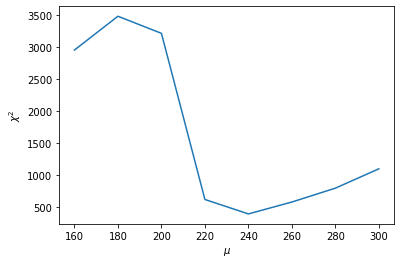

In [21]:
plt.plot(mu_par, Chi_mu)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\chi^2$')

Encontramos un primer mínimo en $\mu$ = 240; probaremos con este valor fijo para hallar mejor c

In [22]:
begin = time.perf_counter() # contaremos el tiempo

mu_fijo = 240.0 #Fijamos mu en valor encontrado 
c_par = np.arange(1, 15, 2.5)  #hacemos barrido sobre posibles valores de c

Chi_c = [] # lista de chi2 en función de c
for c_v in c_par:
  YY = nw_hist((mu_fijo, c_v), bines, n_ent)
  ch_cv = chi_hist(DMP, YY) 
  Chi_c.append(ch_cv)

end = time.perf_counter()

print(f'Tomó {round(end-begin, 2)} segundos ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Tomó 74.74 segundos 


Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).


In [23]:
minc = min(Chi_c)
indexc = Chi_c.index(minc)

print("c mínimo es:", c_par[indexc])

c mínimo es: 6.0


Text(0, 0.5, '$\\chi^2$')

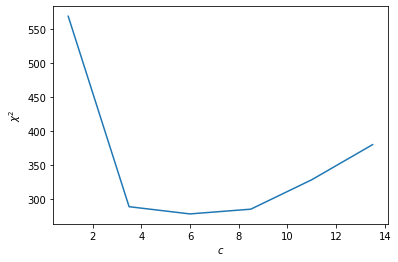

In [24]:
plt.plot(c_par, Chi_c)
plt.xlabel(r'$c$')
plt.ylabel(r'$\chi^2$')

En este caso, encontramos un mínimo en c=6. 

Por lo anterior, tenemos como candidatos a parámetros optimos: $\mu$ = 240 y c = 6. 

Graficamos para ver que tan cerca estamos.

In [25]:
#------- Histograma con parámetros candidatos -------
Hist_pre = nw_hist((240.0, 6.0), bines, n_ent)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).


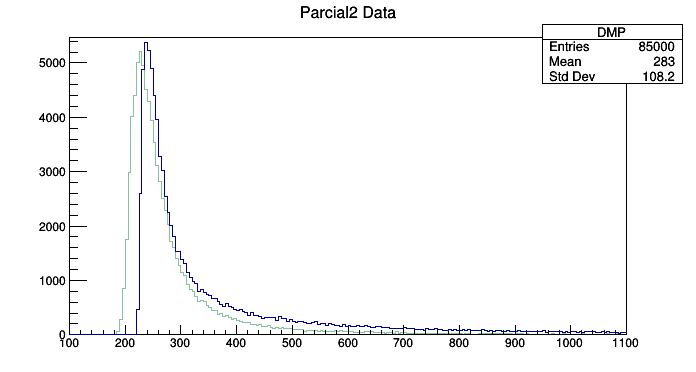

In [26]:
#======== Gráfica superpuesta del ajuste preliminar y los datos =======

DMP.Draw()
DMP.SetLineColor(30) # Datos en Verde
Hist_pre.Draw("same") # Ajuste en azul
c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

Notamos que estamos cerca, por lo tanto haremos un nuevo ajuste con parámetros alrededor de estos puntos con una separación más baja. Es decir, aumentamos la resolución en el barrido de cada parámetro de acuerdo a lo que se nota gráficamente. 

In [29]:
begin = time.perf_counter()

mu_par = np.arange(217.0, 221.0, 0.5) # Variamos mu con mayor resolución en rango más pequeño 
c_fijo = 6.0 # Trabajamos con c optimo hallado 

Chi_mu = []
for mu_v in mu_par:
  YY = nw_hist((mu_v, c_fijo), bines, n_ent)
  ch_uv = chi_hist(DMP, YY) 
  Chi_mu.append(ch_uv)

end = time.perf_counter()

print(f'Tomó {round(end-begin, 2)} segundos ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Tomó 63.17 segundos 


Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).


In [30]:
minmu = min(Chi_mu)
indexmu = Chi_mu.index(minmu)

print("mu mínimo es:", mu_par[indexmu])

mu mínimo es: 218.0


Text(0, 0.5, '$\\chi^2$')

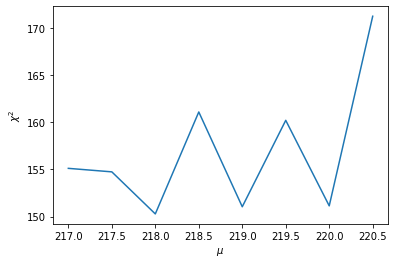

In [31]:
plt.plot(mu_par, Chi_mu)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\chi^2$')

Probaremos que tan bien se ajustan las gráficas con el cambio $\mu$ = 218.0

In [32]:
#---- Generamos Histograma con parámetros refinados

Hist_post = nw_hist((218.0, 6.0), bines, n_ent)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
Warning in <TROOT::Append>: Replacing existing TH1: HIST (Potential memory leak).


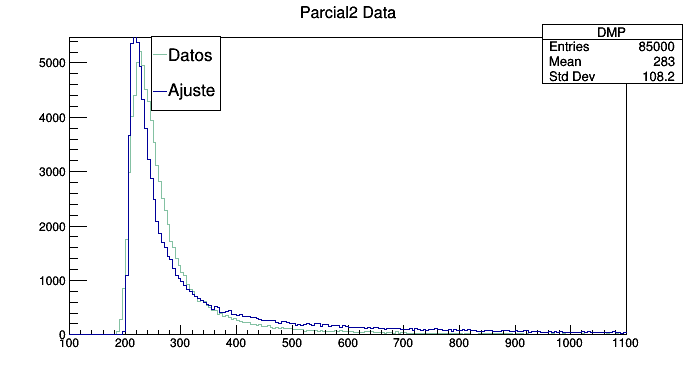

In [75]:
#======== Gráfica superpuesta del ajuste posterior y los datos =======

#--- legenda para gráfica ROOT
legend = ROOT.TLegend(0.1, 0.2)
legend.AddEntry(DMP, "Datos", "l")
legend.AddEntry(Hist_post, "Ajuste", "l")

DMP.Draw()
DMP.SetLineColor(30) # Datos en Verde
Hist_post.Draw("same") # Ajuste en Azul
legend.Draw("same")
c1.Update()
ROOT.gROOT.GetListOfCanvases().Draw()

De esta manera, obtenemos un ajuste a los datos con los parametros $\mu$=218.0 y c=6.0 en la distribución de Landau. 

Haciendo gráfica de $\chi^2$ en función de $\mu$ y c. 

Esta gráfica demora mucho en su elaboración, y se hace solo para cumplir con el entregable, pues el análisis para los parámetros optimos fue el mostrado anteriormente. 

In [0]:
begin = time.perf_counter()

mus = np.arange(150, 260, 20) # Variamos mu a grandes pasos en rango grande 
cs = np.arange(1, 20, 3) # Variamos c a grandes pasos en rango grande  

Chi2 = []
for mu_v in mus:
  subchi = []
  for c_v in cs:
    YY = nw_hist((mu_v, c_v), bines, n_ent)
    ch_uv = chi_hist(DMP, YY) 
    subchi.append(ch_uv)
  Chi2.append(subchi)

end = time.perf_counter()

print(f'Tomó {round(end-begin, 2)} segundos ')

In [47]:
CHI2 = np.array(Chi2)

print(CHI2.shape)

(4, 6)


Haremos mapa de color con el barrido de $\chi^2$ sobre los parámetros $\mu$ y c.

In [0]:
#====== Importamos librería necesaria =======
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [0]:
viridis = cm.get_cmap('Oranges_r', 128)
newcolors = viridis(np.linspace(0, 1, 128))
newcmp = ListedColormap(newcolors)

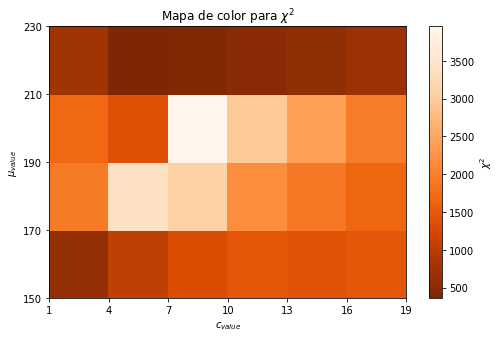

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

psm = ax.pcolormesh(CHI2, cmap=newcmp, rasterized=True)
fig.colorbar(psm, ax=ax, label=r'$\chi^2$')
ax.set_xticks(np.arange(len(cs))); ax.set_xticklabels(cs)
ax.set_yticks(np.arange(len(mus[:-1]))); ax.set_yticklabels(mus[:-1])
ax.set_title(r'Mapa de color para $\chi^2 $')
ax.set_xlabel(r'$c_{value}$')
ax.set_ylabel(r'$\mu_{value}$')
plt.show()

In [0]:
*